In [40]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [41]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
import torch.optim as optim
from torchvision.models import resnet50, ResNet50_Weights
import cv2
import torchvision
import tqdm
import matplotlib.pyplot as plt
import numpy as np
from local_models import *
from helper_functions import *

from livelossplot import PlotLosses
from pathlib import Path
from torch.utils.data import DataLoader

from dataset import SamDataset

In [7]:
resnet = resnet50(weights=ResNet50_Weights.DEFAULT)

In [42]:
dataroot = Path('C:','\\', 'Users', 'michalro', 'chess_detector', 'chessred') #Change this to match the computer you are working from!
data_path=Path(dataroot, 'annotations.json')
if not data_path.is_file():
    raise(FileNotFoundError(f"File '{data_path}' doesn't exist."))
device = 'cuda' if torch.cuda.is_available() else 'cpu' # set the device according to availability
print(f"device = {device}")

device = cuda


In [43]:
train_dataset = SamDataset(dataroot=dataroot, classifier='pb', split='train', crop = False)
val_dataset = SamDataset(dataroot=dataroot, classifier='pb', split='val', crop = False)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True) #batch size might be too small!
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

torch.Size([8, 256, 256, 3])
tensor([0, 1, 0, 1, 1, 0, 1, 0])


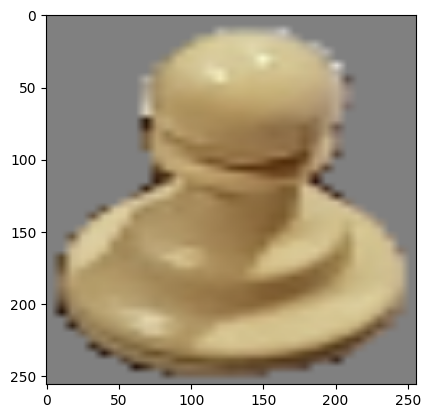

In [28]:
for data, label in train_loader:
    break
# cell to visualize the dataLoader output for crop=false
plt.imshow(data[0])
print(data.shape)
print(label)

## MODEL STARTS HERE

In [44]:
# Load an instance of resnet with pretrained weights.
resnet = resnet50(weights=ResNet50_Weights.DEFAULT).to(device)

# Freeze the weights of resnet (because we want to only train the last layer).
for param in resnet.parameters():
    param.requires_grad = False

# Set the number of classes, and modify the last linear layer of the resnet to output that number of values. 
# This layer will have gradients by default.So it will train.
num_classes = 2  # Number of classes in the dataset
resnet.fc = nn.Linear(resnet.fc.in_features, num_classes).to(device)

# Create the transforms to apply to the data. We assume that the data is similar to that of imagenet since we are dealing with natural images. 
# We therefore want to normalize it to have something around mean=1 and std=1. We will see if our assumption that the values are similar to 
# resnet is correct or if we need to find the original mean and variance ourselves in order to normalize properly.
transform = transforms.Compose([
    PermuteChannelIndex(),
    ScalingTransform(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define the criterion and optimizer to use in training the model.
lr = 0.01
momentum = 0.9
liveloss = PlotLosses()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet.parameters(), lr=lr, momentum=momentum)

In [14]:
# train_dataset = SamDataset(dataroot=dataroot, classifier='pb', split='train', crop = False, transform=transform)
# val_dataset = SamDataset(dataroot=dataroot, classifier='pb', split='val', crop = False, transform=transform)

# train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True) #batch size might be too small!
# val_loader = DataLoader(val_dataset, batch_size=1, shuffle=True)

TypeError: SamDataset.__init__() got an unexpected keyword argument 'transform'

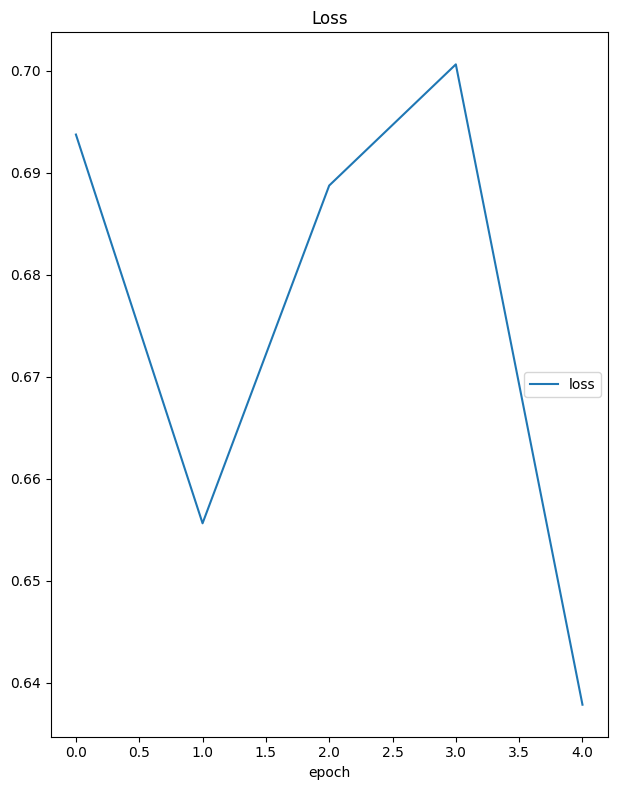

Loss
	loss             	 (min:    0.638, max:    0.701, cur:    0.638)


In [ ]:
# Create the training loop for the model.

# Define the number of epochs
num_epochs = 20 

for epoch in range(num_epochs):
    for data, labels in train_loader:
        data, labels = data.to(device), labels.to(device).long()
        data = transform(data).to(device)
        optimizer.zero_grad()
        outputs = resnet(data).to(device)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # stuff for plotting the loss.
        
        liveloss.update({"loss": loss.item()})
        liveloss.draw()